# The Traveling Team
## Introduction
The main goal of this project was to choose which neighborhood has the most accessible transportation. We did this by analyzing four metrics: public transit, traffic counts, walkability, and bike lanes. By combing these four metrics, we were able to conclude which neighborhood is the best in terms of accessible transportation.

# Metric 1: Accessible Public Transit
For the analysis of the best Pittsburgh neighborhood by most accessible transportation, one of the datasets we chose to analyze was the availability of public transit routes.

In [79]:
import pandas as pd
import geopandas
import numpy as np

Above, I imported the necessary libraries need for my data analysis.

<AxesSubplot: >

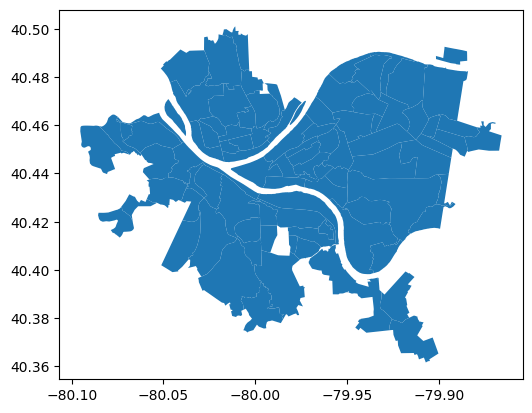

In [80]:
neighborhoods_map = geopandas.read_file('Neighborhoods_.shp')
neighborhoods_map.plot()

Above, I created a map of Pittsburgh neighborhoods that will be filled in with data about transit routes in the steps that follow.

<AxesSubplot: >

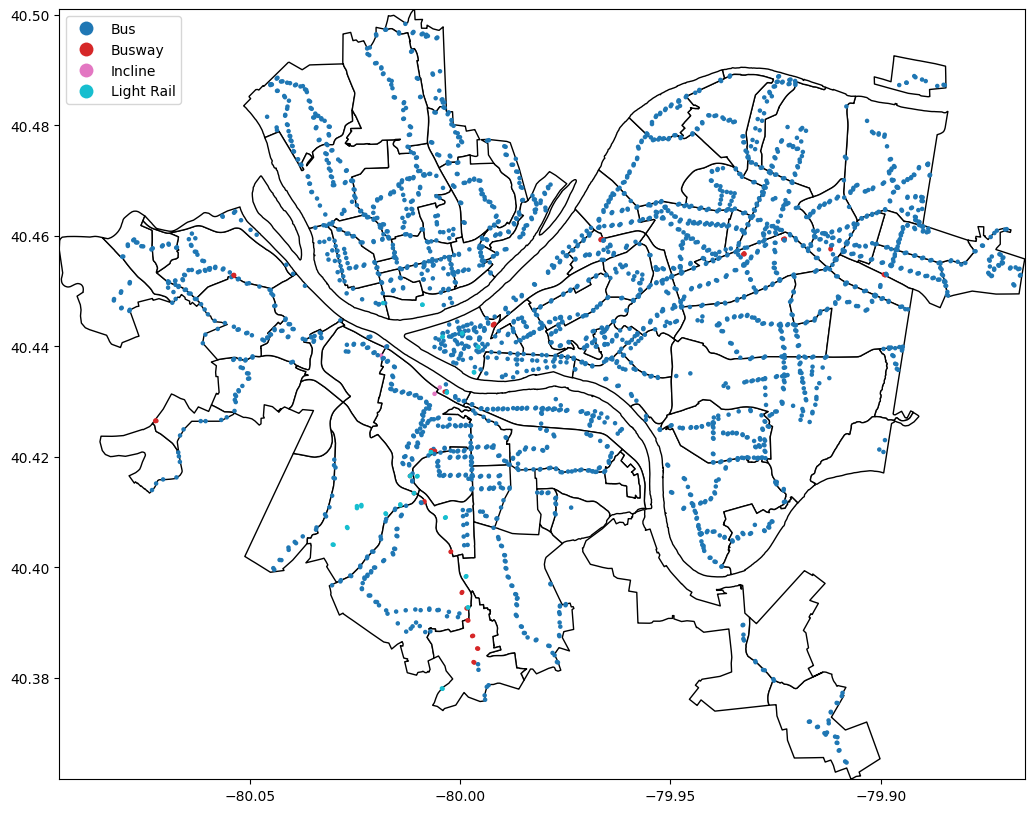

In [81]:
transit_stops = geopandas.read_file('PAAC_Stops_1909.shp')
transit_stops = transit_stops.to_crs(neighborhoods_map.crs)

mask = [True in result.values for result in [neighborhoods_map.contains(point) for point in transit_stops['geometry']]]
points_in_a_pgh_neighborhood = transit_stops.loc[mask]

base = neighborhoods_map.plot(color='white', edgecolor='black', figsize=(15,10))
minx = min(neighborhoods_map.bounds['minx'])
miny = min(neighborhoods_map.bounds['miny'])
maxx = max(neighborhoods_map.bounds['maxx'])
maxy = max(neighborhoods_map.bounds['maxy'])
base.set_xlim(minx, maxx)
base.set_ylim(miny, maxy)
points_in_a_pgh_neighborhood.plot(ax=base, markersize=5, column='Mode', legend=True)

In the above code, I wanted to look into a visual representation of transit stops that were in Pittsburgh neighborhoods specifically. So, using the neighborhoods map as a subplot and masking the transit data to only include points in a neighborhood, I created the above representation.
Once I created that representation, I wanted to figure out the percentage of stops in each neighborhood, which I create a visualization of below.

,objectid,hood,percent_total_stops
41,1334,Central Business District,3.526619
64,1357,Mount Washington,3.255341
22,1315,Lincoln-Lemington-Belmar,3.221431
24,1317,Bloomfield,3.187521
31,1324,Shadyside,3.051882
50,1343,Squirrel Hill South,2.746694
44,1337,Squirrel Hill North,2.644964
4,1297,Perry South,2.644964
49,1342,Greenfield,2.577145
79,1372,Brookline,2.407596


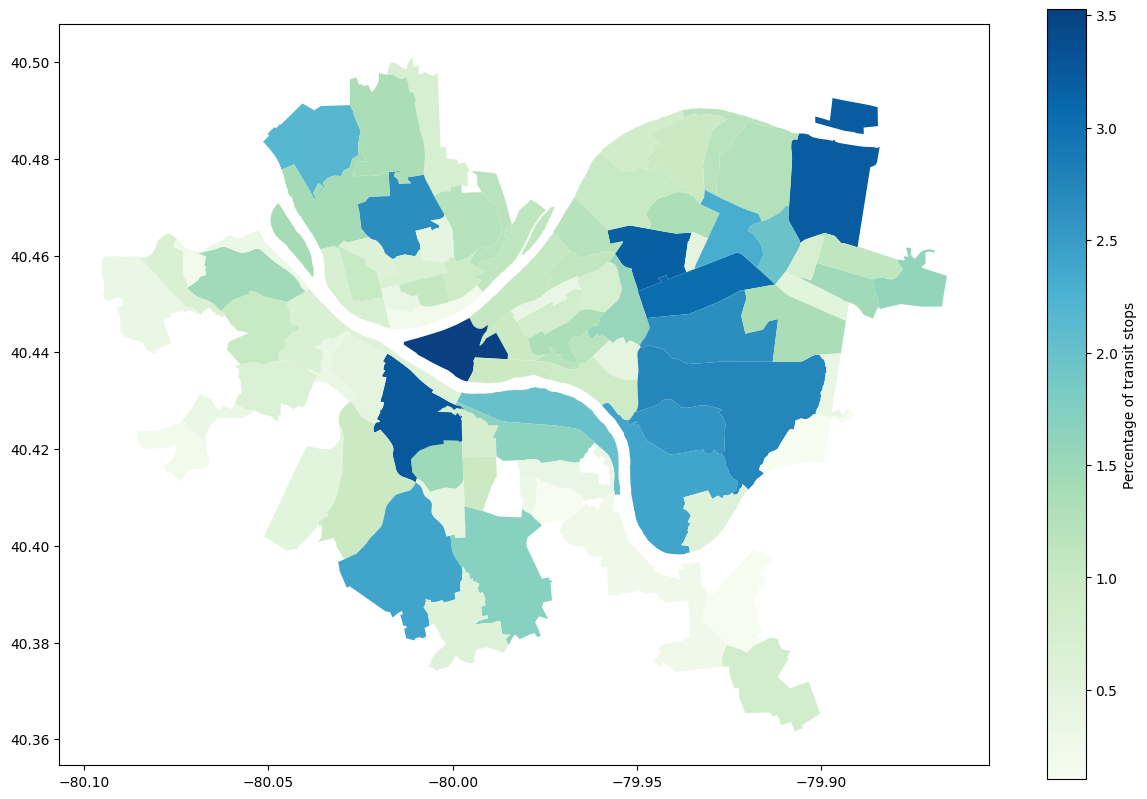

In [82]:
data = {}

for shape, objectid in zip(neighborhoods_map['geometry'], neighborhoods_map['objectid']):
	for point in points_in_a_pgh_neighborhood['geometry']:
		if shape.contains(point):
			if objectid in data:
				data[objectid] += 1
			else:
				data[objectid] = 1	

total_stops = sum(list(data.values()))

for key in data.keys(): # convert to percentages
	data[key] = (data[key] / total_stops) * 100

df_details = {
	'objectid': list(data.keys()),
	'percent_total_stops': list(data.values())
}
df = pd.DataFrame(df_details)
merged_df_percent_total_stops = neighborhoods_map.merge(df, how='left', left_on='objectid', right_on='objectid')
merged_df_percent_total_stops.plot(column='percent_total_stops', legend=True, figsize=(15,10), cmap='GnBu', legend_kwds={'label': 'Percentage of transit stops'})
merged_df_percent_total_stops = merged_df_percent_total_stops.sort_values('percent_total_stops', ascending=False)
merged_df_percent_total_stops.head(10)[['objectid', 'hood', 'percent_total_stops']]

The above map illustrates the neighborhoods of Pittsburgh with the darker colored ones having more stops than the lighter colored ones. By printing out the top 10 values sorted by percentage, we also get the names of the neighborhoods with the most amount of stops.

,objectid,hood,num_routes
41,1334,Central Business District,84.0
82,1375,South Shore,30.0
31,1324,Shadyside,27.0
28,1321,Larimer,24.0
48,1341,South Oakland,21.0
37,1330,North Oakland,20.0
56,1349,Polish Hill,19.0
36,1329,Central Oakland,19.0
38,1331,West Oakland,18.0
12,1305,North Shore,18.0


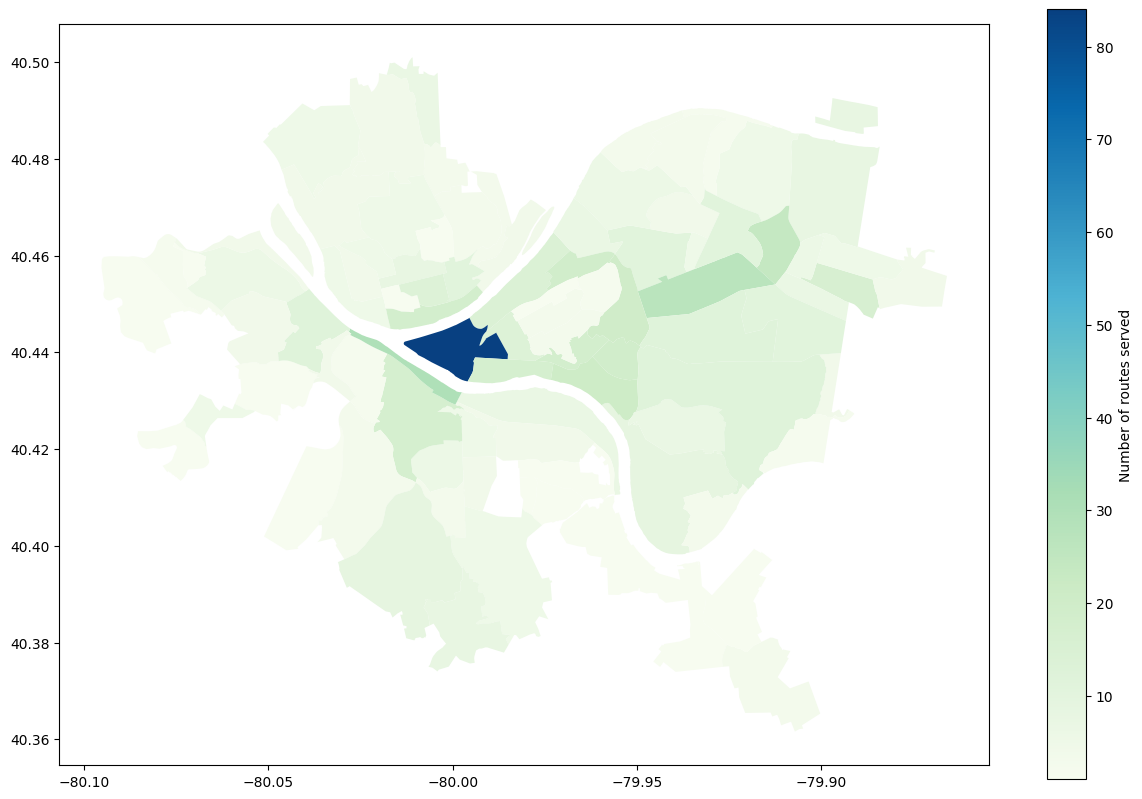

In [83]:
neighborhoods_routes_served = {}

for shape, objectid in zip(neighborhoods_map['geometry'], neighborhoods_map['objectid']):
	for point, routes_served in zip(points_in_a_pgh_neighborhood['geometry'], points_in_a_pgh_neighborhood['Routes_ser']):
		if shape.contains(point):
			if objectid in neighborhoods_routes_served:
				neighborhoods_routes_served[objectid] = neighborhoods_routes_served[objectid].union(set(routes_served.replace(' ', '').split(',')))
			else:
				neighborhoods_routes_served[objectid] = set(routes_served.replace(' ', '').split(','))

num_routes_by_neighborhood = {}
for objectid, routes in neighborhoods_routes_served.items():
	num_routes_by_neighborhood[objectid] = len(routes)

df_details_num_routes = {
	'objectid': list(num_routes_by_neighborhood.keys()),
	'num_routes': list(num_routes_by_neighborhood.values())
}

df_num_routes = pd.DataFrame(df_details_num_routes)

merged_df_num_routes = neighborhoods_map.merge(df_num_routes, how='left', left_on='objectid', right_on='objectid')
merged_df_num_routes.plot(column='num_routes', legend=True, figsize=(15,10), cmap='GnBu', legend_kwds= {'label': 'Number of routes served'})
merged_df_num_routes = merged_df_num_routes.sort_values('num_routes', ascending=False)
merged_df_num_routes.head(10)[['objectid', 'hood', 'num_routes']]

After examining the number of stops by neighborhood, my next thought was the fact that just because a neighborhood has a lot of transit stops, does not mean that it's accessible to other parts of the city because what if a large number of transit stops take up one route? So, I chose to examine the amount of routes served in a neighborhood as part of my analysis. As shown above, we can see the amount of routes served by neighborhood

,objectid,hood,num_routes
82,1375,South Shore,30.0
31,1324,Shadyside,27.0
28,1321,Larimer,24.0
48,1341,South Oakland,21.0
37,1330,North Oakland,20.0
56,1349,Polish Hill,19.0
36,1329,Central Oakland,19.0
38,1331,West Oakland,18.0
12,1305,North Shore,18.0
64,1357,Mount Washington,17.0


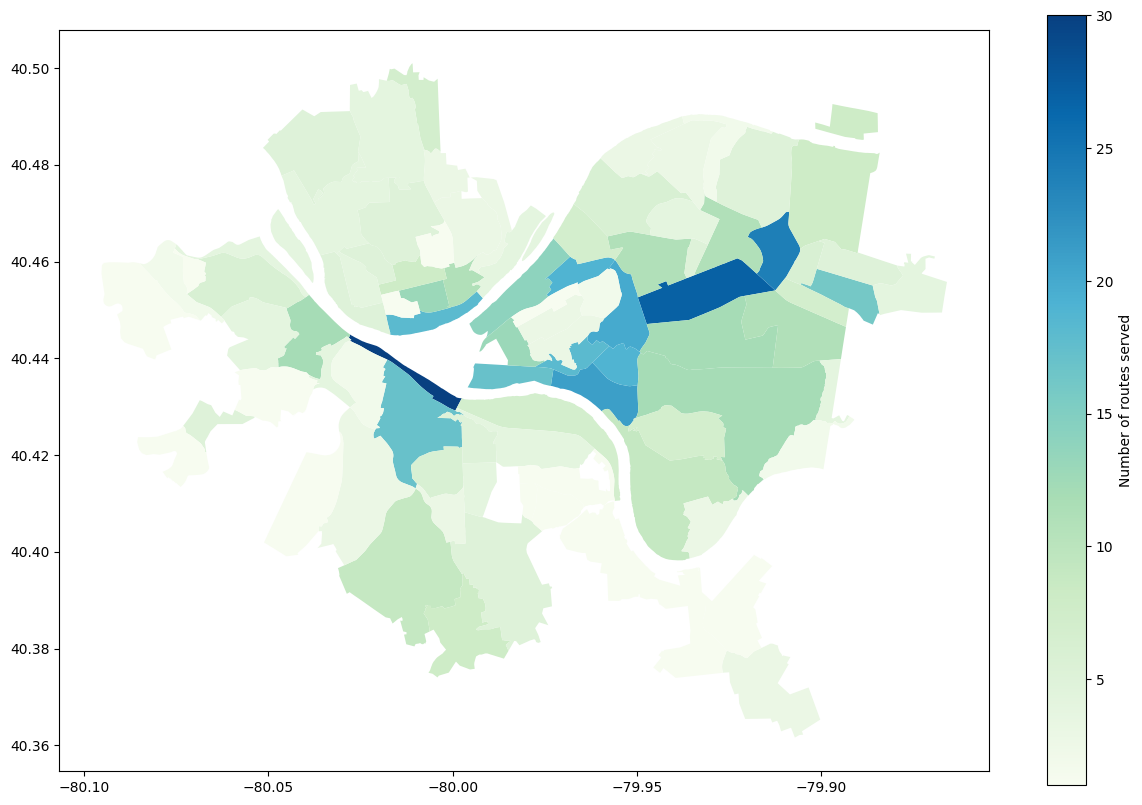

In [84]:
merged_df_num_routes_no_outlier = merged_df_num_routes[merged_df_num_routes.objectid != 1334]
merged_df_num_routes_no_outlier.plot(column='num_routes', legend=True, figsize=(15,10), cmap='GnBu', legend_kwds= {'label': 'Number of routes served'})
merged_df_num_routes_no_outlier.sort_values('num_routes', ascending=False)[['objectid', 'hood', 'num_routes']].head(10)

After noticing the outlier in the Central Business District, I wanted to create a second visualization in order to better represent the number of routes served per neighborhood. Finally, below I created bar graphs of the information represented by the above heat maps.

<AxesSubplot: ylabel='hood'>

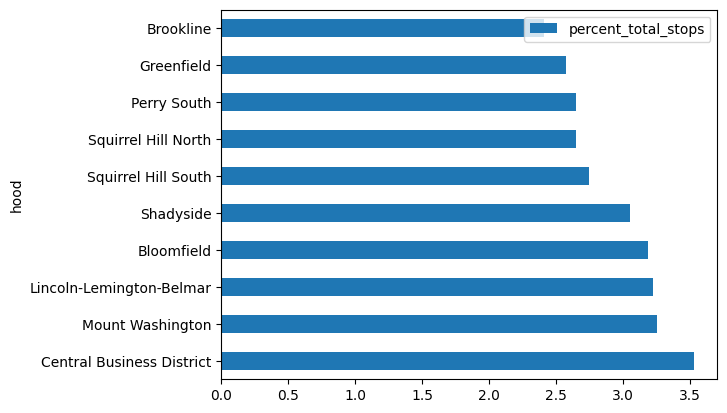

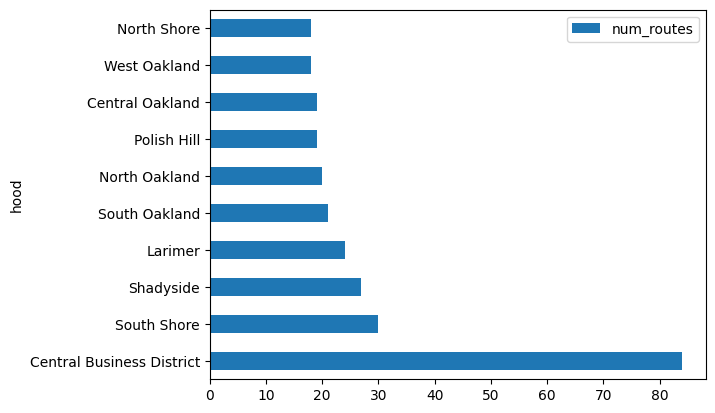

In [85]:
merged_df_percent_total_stops.head(10).plot.barh(x='hood', y='percent_total_stops')
merged_df_num_routes.head(10).plot.barh(x='hood', y='num_routes')

# Metric 2: Traffic Count
For the analysis of the best Pittsburgh neighborhood by most accessible transportation, one of the datasets we chose to analyze was the amount of traffic in an area. This was chosed under the assumption that less traffic in an area makes for quicker traffic time, and reliable public transit.

In [86]:
neighborhoods = geopandas.read_file('Neighborhoods_.shp')
neighborhoods

,objectid,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,...,page_numbe,plannerass,created_us,created_da,last_edite,last_edi_1,temp,Shape__Are,Shape__Len,geometry
0,1293,201,42,003,980600,1,420039806001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14,pgh.admin,2020-08-14,None,1.068796e+07,19600.573085,"POLYGON ((-80.02999 40.45909, -80.02989 40.458..."
1,1294,10,42,003,261200,1,420032612001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14,pgh.admin,2020-08-14,None,1.133208e+07,21174.473326,"POLYGON ((-80.01078 40.49975, -80.01073 40.499..."
2,1295,11,42,003,260900,1,420032609001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14,pgh.admin,2020-08-14,None,8.743618e+06,13811.917169,"POLYGON ((-80.00327 40.48271, -80.00325 40.482..."
3,1296,7,42,003,262000,1,420032620001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14,pgh.admin,2020-08-14,None,1.754935e+07,18197.745741,"POLYGON ((-79.99761 40.47460, -79.99761 40.474..."
4,1297,8,42,003,261500,1,420032615001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14,pgh.admin,2020-08-14,None,2.522420e+07,26390.549314,"POLYGON ((-80.01422 40.47745, -80.01435 40.477..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,1378,251,42,003,320400,3,420033204003,Block Group 3,G5030,S,...,15,Sophia Robison,pgh.admin,2020-08-14,pgh.admin,2020-08-14,None,2.338689e+07,31964.844864,"POLYGON ((-79.99633 40.39458, -79.99630 40.394..."
86,1379,265,42,003,563000,4,420035630004,Block Group 4,G5030,S,...,15,Sophia Robison,pgh.admin,2020-08-14,pgh.admin,2020-08-14,None,3.683820e+06,9978.225999,"POLYGON ((-80.06919 40.46046, -80.06912 40.460..."
87,1380,358,42,003,562500,1,420035625001,Block Group 1,G5030,S,...,15,Sophia Robison,pgh.admin,2020-08-14,pgh.admin,2020-08-14,None,6.425358e+06,25260.814467,"POLYGON ((-80.05154 40.46364, -80.05140 40.463..."
88,1381,298,42,003,563100,3,420035631003,Block Group 3,G5030,S,...,15,Sophia Robison,pgh.admin,2020-08-14,pgh.admin,2020-08-14,None,1.027920e+07,16308.247349,"POLYGON ((-80.03431 40.43366, -80.03424 40.433..."


In [87]:
traffic_data = pd.read_csv('traffic_data.csv')
traffic_data = traffic_data[~traffic_data.average_daily_car_traffic.isnull()]
traffic_data

,id,device_id,record_oid,count_start_date,count_end_date,average_daily_car_traffic,average_daily_bike_traffic,counter_number,counter_type,speed_limit,...,longitude,latitude,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone
0,1011743669,85,1.445865e+09,2019-04-18,2019-04-26,4949.0,NaN,6,StatTrak,25.0,...,-79.967772,40.455733,Polish Hill,7.0,6.0,42003060500,6.0,6.0,2.0,2-6
3,103627606,9,7.341951e+08,2018-07-17,2018-08-01,2741.0,NaN,NaN,StatTrak,25.0,...,-79.914335,40.437379,Squirrel Hill South,5.0,14.0,42003140800,3.0,14.0,4.0,2-18
5,1041392556,76,5.713472e+08,2019-03-22,2019-03-29,1046.0,NaN,2,StatTrak,25.0,...,-80.014234,40.458106,Central Northside,6.0,25.0,42003250300,1.0,25.0,1.0,1-21
7,1053645660,87,8.042089e+08,2019-04-18,2019-04-26,3015.0,NaN,4,StatTrak,25.0,...,-79.964592,40.457119,Polish Hill,7.0,6.0,42003060500,6.0,6.0,2.0,2-6
10,1102260248,8,1.088318e+09,2018-07-16,2018-08-01,5592.0,NaN,NaN,StatTrak,25.0,...,-79.911925,40.435620,Squirrel Hill South,5.0,14.0,42003140800,3.0,14.0,4.0,2-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,5216219,421,1.382452e+09,2021-06-29,2021-07-07,5605.0,NaN,7,StatTrak,25.0,...,-79.926715,40.425958,Greenfield,5.0,15.0,42003151700,3.0,15.0,4.0,2-15
404,1671608614,423,1.290716e+09,2021-06-15,2021-06-23,809.0,NaN,1,StatTrak,25.0,...,-80.010193,40.457801,Central Northside,6.0,25.0,42003250300,1.0,25.0,1.0,1-21
410,1140544457,429,1.023986e+09,2021-07-09,2021-07-19,910.0,NaN,2,StatTrak,25.0,...,-79.940428,40.461034,Bloomfield,7.0,8.0,42003080600,2.0,8.0,5.0,3-23
411,742131013,430,1.933385e+09,2021-07-09,2021-07-19,271.0,NaN,3,StatTrak,25.0,...,-79.953005,40.465173,Bloomfield,7.0,9.0,42003090300,2.0,9.0,5.0,3-6


I started by importing the neighborhoods data to be used later, as well as the traffic data. Since I want to measure this metric based on car traffic, I cleaned the data taking out any rows that did not have any car traffic logged.

,hood,average_daily_car_traffic
50,South Side Flats,115.000000
31,Lincoln Place,126.000000
32,Lincoln-Lemington-Belmar,195.000000
22,Fineview,419.000000
1,Allegheny West,477.000000
38,New Homestead,666.000000
41,Overbrook,777.000000
59,Summer Hill,937.000000
60,Upper Hill,953.333333
13,Central Northside,1189.000000


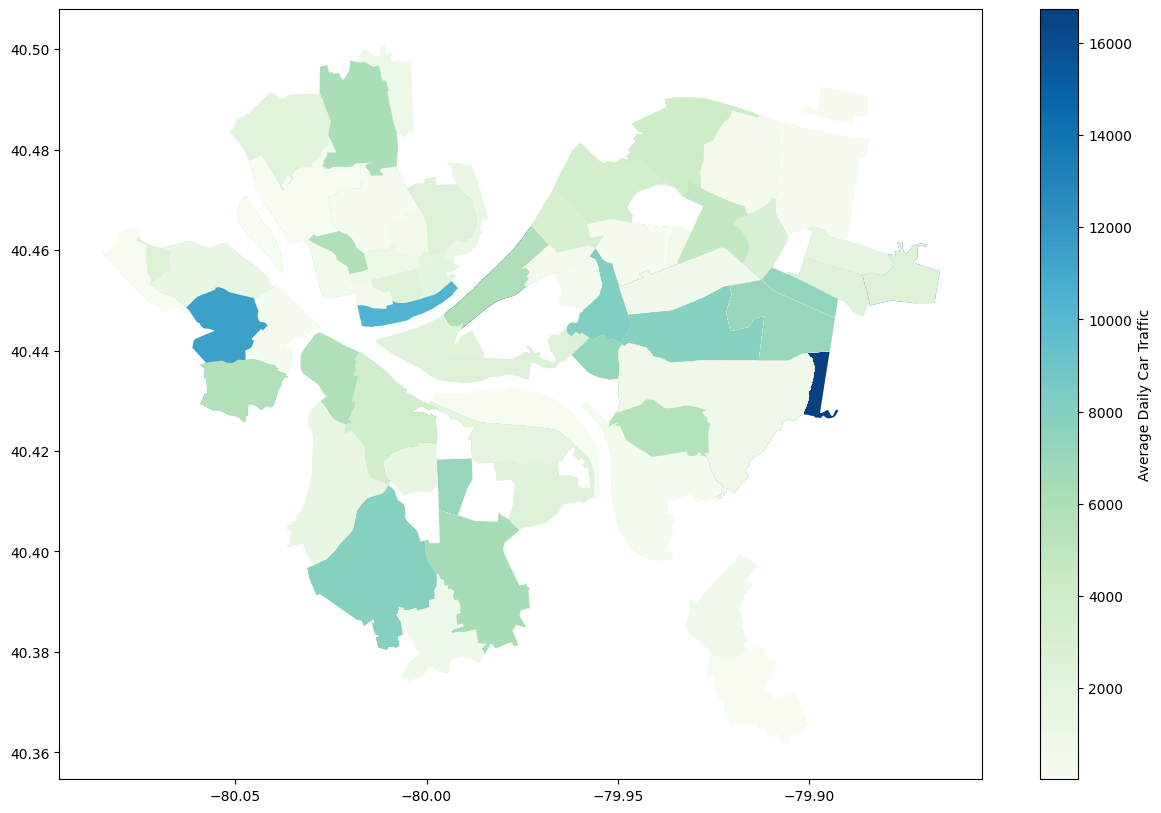

In [88]:
traffic_data_and_hood_id = neighborhoods.merge(traffic_data, how='inner', left_on='hood', right_on='neighborhood')
traffic_data_and_hood_id.plot(figsize=(15,10), column='average_daily_car_traffic', legend=True, cmap='GnBu', legend_kwds={'label': 'Average Daily Car Traffic'})

traffic_data_and_hood_id_summed_df = traffic_data_and_hood_id.groupby('hood', as_index=False).mean(numeric_only=True).sort_values('average_daily_car_traffic')
traffic_data_and_hood_id_summed_df.head(10)[['hood', 'average_daily_car_traffic']]

The above map illustrates the average car traffic in the neighborhoods of Pittsburgh (that have traffic data). The darker colors on the heatmap represent higher traffic areas, whereas the lighter colored areas represent lower traffic areas. Additionally, we can see the top 10 lowest traffic areas by looking at the head of the sorted dataset. This same information is illustrated on the below bar chart.

<AxesSubplot: ylabel='hood'>

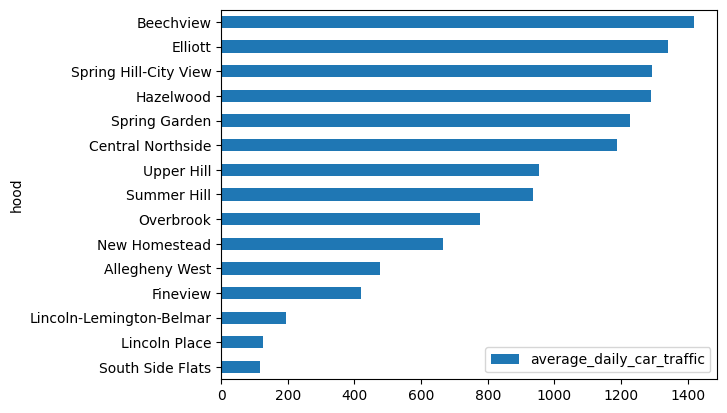

In [89]:
traffic_data_and_hood_id_summed_df.head(15).plot.barh(x='hood', y='average_daily_car_traffic')

# Metric 3: Sidewalk to Street "Walkability" Ratio

For the analysis of the best Pittsburgh neighborhood by most accessible transportation, one of the datasets we chose to analyze was the sidewalk to street "walkability" ratio. This was chosen in the case that someone would want to travel on foot in a given location as their means of transportation. A ratio of 1 means that there is equal length of sidewalk to street ratio, and a ratio of 2 means that there is double the length of sidewalk compared to street. 

In [90]:
pgh_neiborhood=pd.read_csv("neighborhoods.csv")
pgh_neiborhood.head(10)
pgh_neiborhood[['hood', 'hood_no', 'geoid10']].head(10)

,hood,hood_no,geoid10
0,Chateau,22,420039806001
1,Summer Hill,81,420032612001
2,Northview Heights,58,420032609001
3,Spring Hill-City View,75,420032620001
4,Perry South,62,420032615001
5,Fineview,33,420032509002
6,Central Northside,19,420032503001
7,Spring Garden,74,420032412002
8,Troy Hill,84,420032406002
9,East Allegheny,26,420035632003


I first opened the file containing all neighboorhoods in Pittsburgh and removed all irrelevant columns to the final goal. This left the neighborhood name, number, and a designated geoid number. 

In [91]:
pgh_walkratio=pd.read_csv("SidewalkStreetRatio.csv")
pgh_walkratio[['GEOID', 'Ratio']].head(10)

,GEOID,Ratio
0,420030103001,0.441776
1,420030103002,1.551697
2,420030103003,1.538866
3,420030103004,1.249711
4,420030201001,1.799394
5,420030201002,1.743155
6,420030201003,2.303707
7,420030201004,1.640231
8,420030201005,1.354883
9,420030201006,1.429927


After that, I looked into the data from studies containing the ratios of sidewalks to streets in neighborhoods. This data does not contain the names of each neighboorhood; instead, it contains the geoid of each neighboorhood and its corresponding ratio of sidewalks to streets. A higher ratio meant that there were more sidewalks in comparison to the number of streets. 

In [92]:
pgh_neiborhood=pd.read_csv("neighborhoods.csv")

pgh_walkratio=pd.read_csv("SidewalkStreetRatio.csv")
pgh_walkratio['GEOID'] = pgh_walkratio['GEOID'].astype(str) #GEOID is int type --> convert to string to map with object type

ratiodict = pgh_walkratio.set_index('GEOID')['Ratio'].to_dict()

pgh_neiborhood['Ratio'] = pgh_neiborhood.geoid10.map(ratiodict)
sidewalk_ratioByHood=pgh_neiborhood[['objectid', 'hood','Ratio']].sort_values(by='Ratio', ascending=False)
print(sidewalk_ratioByHood.head(20))

    objectid                      hood     Ratio
57      1350         Bedford Dwellings  6.644908
44      1337       Squirrel Hill North  3.615286
13      1306          Allegheny Center  3.227465
22      1315  Lincoln-Lemington-Belmar  3.092941
45      1338           Terrace Village  3.017543
2       1295         Northview Heights  2.712593
33      1326            Homewood North  2.512087
26      1319                  Garfield  2.322960
32      1325        Point Breeze North  2.319320
24      1317                Bloomfield  2.265926
85      1378                 Overbrook  2.232174
35      1328              East Liberty  2.116163
60      1353               Beltzhoover  2.021953
27      1320               Morningside  2.016948
81      1374                  Sheraden  1.952216
29      1322                Friendship  1.816415
38      1331              West Oakland  1.773651
53      1346              Point Breeze  1.766703
7       1300             Spring Garden  1.738268
71      1364        

Because we only had the geoid from the previous dataset and we were looking for the actual neighborhood names to compare, I matched the geoid from the first dataset to the ones from the second data set to link the neighborhood names from the first dataset to the ratios from the second. 

<AxesSubplot: xlabel='hood'>

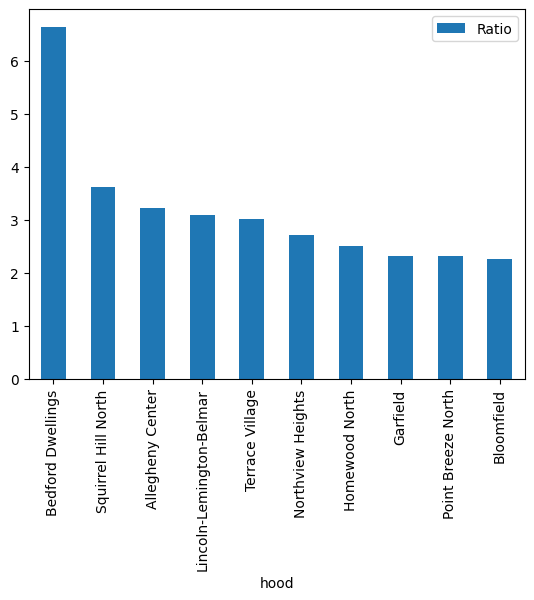

In [93]:
sidewalk_ratioByHood.head(10).plot.bar('hood', 'Ratio')

# Metric 4: Availability of Bike Lanes

Another way we plan on assessing which Pittsburgh neighborhood is the best is through the availability of bike lanes

<AxesSubplot: >

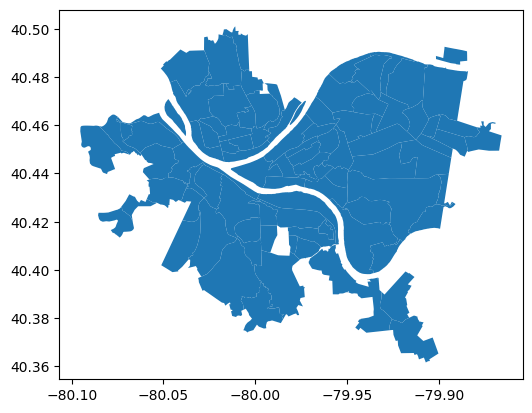

In [94]:
import pandas as pd
import geopandas
neighborhoods = geopandas.read_file('Neighborhoods_.shp')
neighborhoods.plot()

First I created a map of the Pittsburgh neighborhoods which will be filled in with data from the bike lanes shape files

In [95]:
bike_lanes = geopandas.read_file('Bike Lanes.shp')
bike_lanes

,Id,BLName,BLDist,Year_Added,BikeInfDis,Note,CrossSt,SLMDist,RBL,RS,YearTot,BL_SYearTo,geometry
0,0,6th St.,0.091321,2015,0.10,Bike Lane,Penn to Bridge,0.00,None,None,6.18,None,"LINESTRING (1341574.500 412596.500, 1341718.25..."
1,0,Federal St./6th St.,0.060651,2015/2016,0.30,Bike Lane,Bridge to Isabella/North to Hemlock,0.00,None,None,None,4.38,"LINESTRING (1341233.904 413928.936, 1341305.25..."
2,0,Schenley Drive,0.108539,None,0.00,Bike Lane,None,0.00,None,None,None,None,"LINESTRING (1355480.000 411449.000, 1355377.25..."
3,0,S Bouquet St.,0.176892,2013,0.22,Bike Lane,None,0.00,None,None,5.97,None,"LINESTRING (1354430.000 411526.250, 1355172.00..."
4,0,Biglow Blvd (Fifth to Parkman),0.122549,None,0.00,Bike Lane,None,0.00,None,None,None,None,"LINESTRING (1354915.250 412414.000, 1354480.50..."
5,0,O'Hara St to Bayard St.,0.777993,2015,1.60,Bike Lane,DeSoto to Morewood,0.00,None,None,None,None,"LINESTRING (1353483.750 411986.500, 1353759.77..."
6,0,Neville St.,0.169582,2012,0.23,Bike Lane,Fifth to Near Ellsworth,0.00,None,None,None,None,"LINESTRING (1356742.750 414232.750, 1357006.93..."
7,0,East St.,1.458084,2015/2016,3.60,Bike Lane,DeSoto to Morewood/Suffolk to Mt Pleasant,0.00,None,None,None,None,"LINESTRING (1341022.250 426591.000, 1341057.00..."
8,0,Rankin Bridge,0.479848,None,0.00,Bike Lane,None,0.00,None,None,None,None,"LINESTRING (1374578.000 397194.250, 1376346.25..."
9,0,Brereton St.,0.167146,2013,0.30,Bike Lane,Penn to Dobson,0.00,None,None,None,2.34,"LINESTRING (1349952.802 416617.882, 1350089.50..."


Above is the data that will be used to map bike lane availability in the Pittsburgh neighborhoods

<AxesSubplot: >

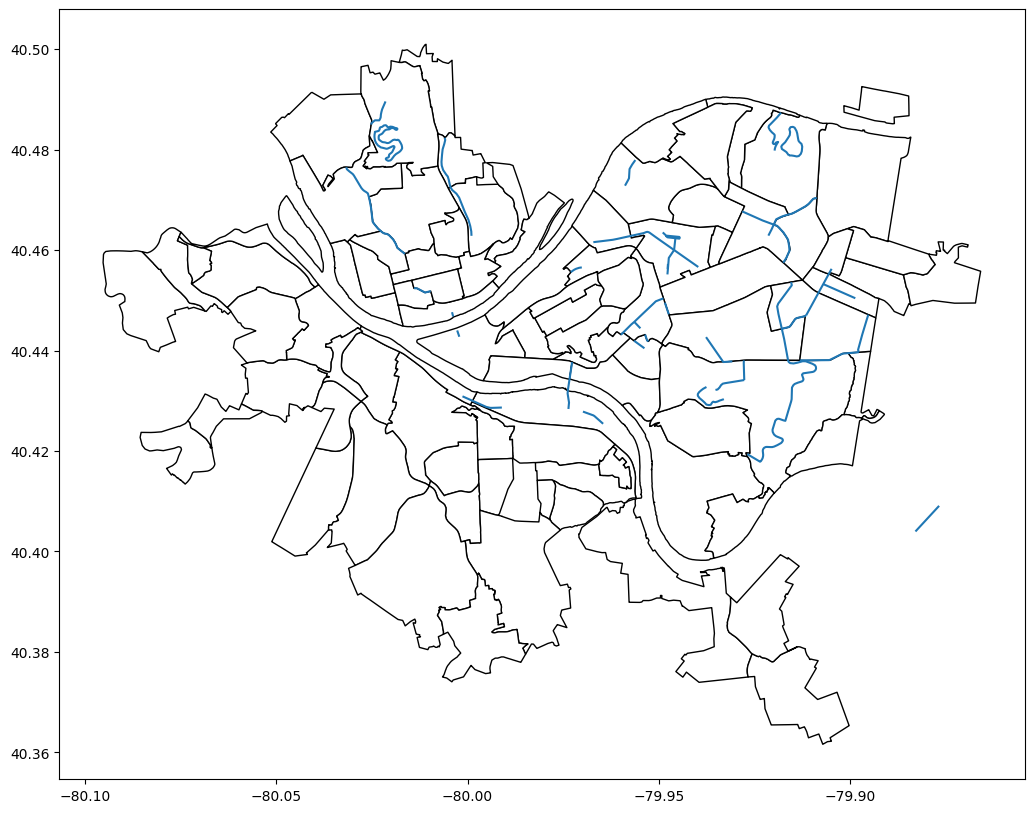

In [96]:
bike_lanes = bike_lanes.to_crs(neighborhoods.crs)
base = neighborhoods.plot(color='white', edgecolor='black', figsize=(15,10))
bike_lanes
bike_lanes.plot(ax=base, markersize=5)

Now, each bike lane present in the data can be shown on the map of Pittsburgh neighborhoods

<AxesSubplot: >

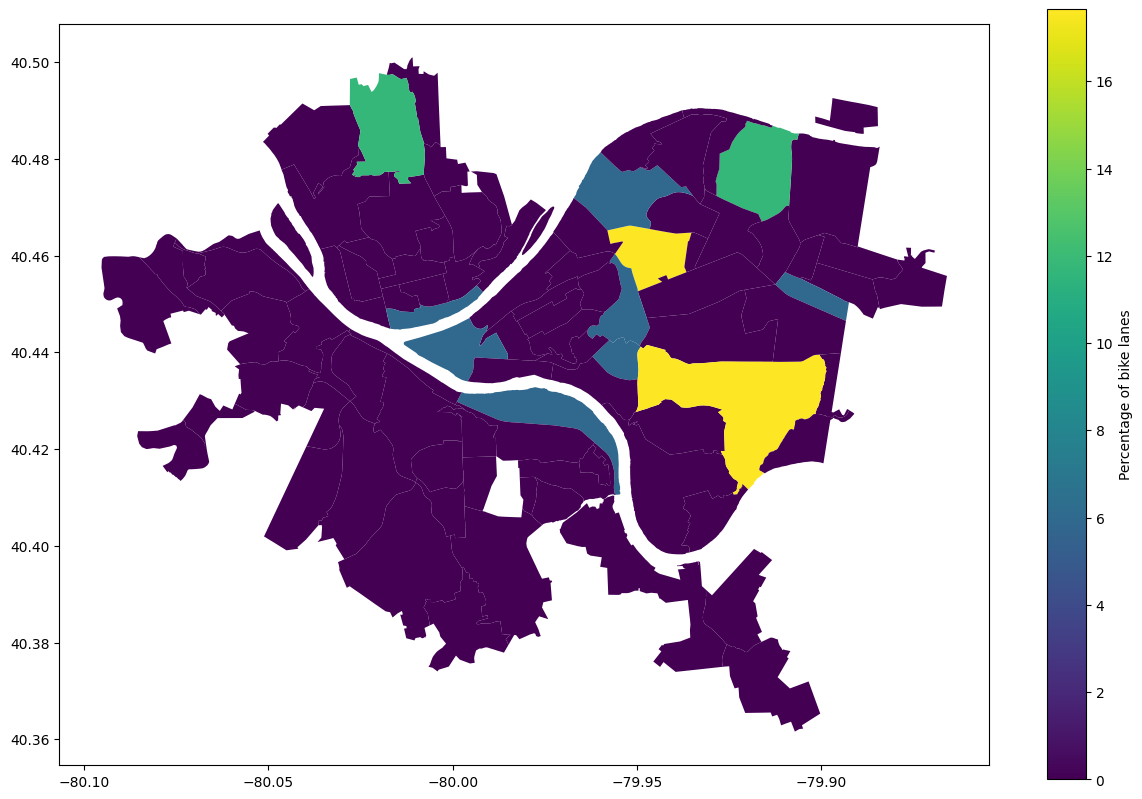

In [97]:
data = {}
for shape, objectid in zip(neighborhoods['geometry'], neighborhoods['objectid']):
	for line in bike_lanes['geometry']:
		if shape.contains(line):
			if objectid in data:
				data[objectid] += 1
			else:
				data[objectid] = 1
		else:
			if objectid not in data:
				data[objectid] = 0
total_bike_lanes = sum(list(data.values()))
for key in data.keys():
	data[key] = (data[key] / total_bike_lanes) * 100
df_details = {

	'objectid': list(data.keys()),
	'percent_total_bike_lanes': list(data.values())
}
df = pd.DataFrame(df_details)
merged_df_percent_total_bike_lanes = neighborhoods.merge(df, how='left', left_on='objectid', right_on='objectid')
merged_df_percent_total_bike_lanes.plot(column='percent_total_bike_lanes', legend=True, figsize=(15,10), legend_kwds={'label': 'Percentage of bike lanes'})

This map shows what precentage of Pittsburgh's bike lanes each neighborhood has, The lighter the neighborhood, the more bike lanes are present.

In conclusion, when it comes down to bike lane availability, Squirrel Hill South and Bloomfield would be considered the best neighborhoods since they have the most bike lanes

# The Merge

In [98]:
merged_frames = [merged_df_num_routes, traffic_data_and_hood_id_summed_df[['objectid', 'average_daily_car_traffic']], sidewalk_ratioByHood, merged_df_percent_total_bike_lanes[['objectid', 'percent_total_bike_lanes']]]
result = pd.concat(merged_frames, join='inner', axis=1)
result.sort_values(by=['num_routes', 'average_daily_car_traffic', 'Ratio', 'percent_total_bike_lanes'], ascending=[False, True, False, False])
result.head(10)[['objectid', 'hood', 'num_routes', 'average_daily_car_traffic', 'Ratio', 'percent_total_bike_lanes']]

,objectid,objectid,objectid,objectid,hood,hood,num_routes,average_daily_car_traffic,Ratio,percent_total_bike_lanes
41,1334,1378.0,1334,1334,Central Business District,Central Business District,84.0,777.000000,1.640231,5.882353
31,1324,1312.0,1324,1324,Shadyside,Shadyside,27.0,126.000000,1.227199,0.000000
28,1321,1314.0,1321,1321,Larimer,Larimer,24.0,4274.200000,1.591352,0.000000
48,1341,1324.0,1341,1341,South Oakland,South Oakland,21.0,4408.800000,0.991280,0.000000
37,1330,1357.0,1330,1330,North Oakland,North Oakland,20.0,5259.555556,1.115861,5.882353
56,1349,1361.0,1349,1349,Polish Hill,Polish Hill,19.0,2436.000000,1.063583,0.000000
36,1329,1320.0,1329,1329,Central Oakland,Central Oakland,19.0,2049.285714,1.602082,5.882353
38,1331,1313.0,1331,1331,West Oakland,West Oakland,18.0,666.000000,1.773651,0.000000
12,1305,1335.0,1305,1305,North Shore,North Shore,18.0,2249.833333,1.168406,5.882353
46,1339,1349.0,1339,1339,Bluff,Bluff,17.0,2649.000000,1.551697,0.000000


Above, each of the datasets for each metric were merged into one and sorted by the each value.

# Conclusion
Above, we merged the values from each dataset and found that the Central Business District is the best neighborhood to live in based on all of the metrics we measured.

# Personal Conclusions:

**Michael:** When it comes to public transit availability, the Central Business District would be the best. Additionally, when analyzing overall traffic count the South Side Flats would be the best. Overall, my favorite neighborhood is Shadyside. I like how it's close to the city but still offers a "homey" feel, and I just appriciate the area in general.
<br /><br />
**Ethan Z:** My personal decision on best neighborhood for transportation is Squirrel Hill in my experience because I prefer to walk/bike as transportation and the neighborhood is relatively scenic as well
<br /><br />
**Ethan S.** When it comes down to bike lane availability, Squirrel Hill South and Bloomfield would be considered the best neighborhoods since they have the most bike lanes. Personally, I've ran through Squirrel Hill often so I would say that out of these two neighborhoods, Squirrel Hill is the best neighborhood